# Introduction

Market Basket Analysis (MBA) is a popular data mining technique leveraged by retailers to discover customer purchasing patterns. By analyzing point of sale data, it identifies correlations between items based on their co-occurrence in transactions. This technique is pivotal in understanding customer behavior, influencing decisions on product placements, up-selling, cross-selling, and pricing strategies.

A notable application of MBA is Amazon's "Frequently bought together" section. This strategy, rooted in traditional retail practices, encourages additional purchases by suggesting items that are often bought together.

Among the techniques used for MBA, Association Rules and the Apriori Algorithm are widely recognized. Association Rules identify co-occurring items in transaction data, while the Apriori Algorithm, using support and confidence metrics, identifies significant associations among these items.

In this guide, we'll implement Market Basket Analysis using the Apriori Algorithm and Association Rules in Python with the Instacart dataset. This dataset, containing over 30 million orders, provides a robust context for discovering interesting purchasing patterns.

## The key metrics:

- **Support:** A measure of an item's overall presence in the total transactions. For example, if 'milk' appears in 100 out of 1000 transactions, its support is 10%.

- **Confidence:** This gauges the likelihood that a customer purchasing item A will also purchase item B. For instance, if 'bread' and 'butter' are bought together in 50 out of the 100 transactions where 'bread' is bought, the confidence of the rule 'if bread then butter' is 50%.

- **Lift:** This metric assesses the boost in the sale of item A when item B is sold. A lift greater than 1 indicates that items A and B are more likely to be bought together than separately. Conversely, a lift less than 1 suggests that customers are less likely to buy A and B together.

## Data Preprocessing

In [1]:
# Import necessary libraries
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori, association_rules

# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set the pandas display option to format float numbers to 2 decimal places
pd.set_option('display.float_format', '{:.2f}'.format)

# Set the maximum column width to display all the content in a DataFrame cell
pd.set_option('display.max_colwidth', None)

In [3]:
# Loading the orders and products data
orders_data = pd.read_csv("../input/instacart-market-basket-analysis/order_products__prior.csv")
products_data = pd.read_csv("../input/instacart-market-basket-analysis/products.csv")

In [4]:
# Display the first few rows of the orders DataFrame
orders_data.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
# Display the first few rows of the products DataFrame
products_data.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
# Merging the orders and products dataframes on 'product_id'
merged_df = pd.merge(orders_data, products_data, on='product_id', how='inner')

# Display the first few rows of the merged DataFrame
merged_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,26,33120,5,0,Organic Egg Whites,86,16
2,120,33120,13,0,Organic Egg Whites,86,16
3,327,33120,5,1,Organic Egg Whites,86,16
4,390,33120,28,1,Organic Egg Whites,86,16


In [7]:
# Print the number of missing values in the dataset
print(f"The are {merged_df.isna().sum().sum()} missing values in the dataset")

The are 0 missing values in the dataset


In [8]:
# Print the length of the dataframe
print('The length of the dataframe is: {:,}'.format(len(merged_df)))

The length of the dataframe is: 32,434,489


In [9]:
# Print the number of unique products in the dataset
print(f'There are {merged_df.product_id.nunique()} unique products in the dataset')

There are 49677 unique products in the dataset


*Due to memory constrains, we're keeping only 450 out of the 49677 products.*

In [10]:
# Function to calculate top frequent products
def calculate_top_frequent_products(df, top_n):
    product_frequency = df.groupby('product_id')['order_id'].count().reset_index()
    product_frequency.rename(columns = {'order_id':'frequency'}, inplace=True)
    top_frequent_products = product_frequency.nlargest(top_n, 'frequency')
    return top_frequent_products.merge(products_data, on='product_id', how='left')

# Calculate top frequent products
top_frequent_products = calculate_top_frequent_products(merged_df, 450)

# Creating a list of the product_ids of the top frequent products
frequent_product_ids = list(top_frequent_products.product_id)

# Print the total number of frequent products
print(f"The new dataframe contain {len(frequent_product_ids)} unique product")

The new dataframe contain 450 unique product


In [11]:
# Filter merged_orders_products to include only the top frequent products
filtered_data = merged_df[merged_df['product_id'].isin(frequent_product_ids)]

# Display the first few rows of the new filtered DataFrame
filtered_data.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,26,33120,5,0,Organic Egg Whites,86,16
2,120,33120,13,0,Organic Egg Whites,86,16
3,327,33120,5,1,Organic Egg Whites,86,16
4,390,33120,28,1,Organic Egg Whites,86,16


In [12]:
# Print the length of the new dataframe with comma as thousand separator
print('The length of the new dataframe is: {:,}'.format(len(filtered_data)))

The length of the new dataframe is: 13,395,934


*We're using only 41.27% of our original dataset.*

In [13]:
# Print the number of different orders in the new dataframe
print("The new dataframe contains {:,} different orders".format(filtered_data.order_id.nunique()))

The new dataframe contains 2,783,957 different orders


## Exploratory Data Analysis

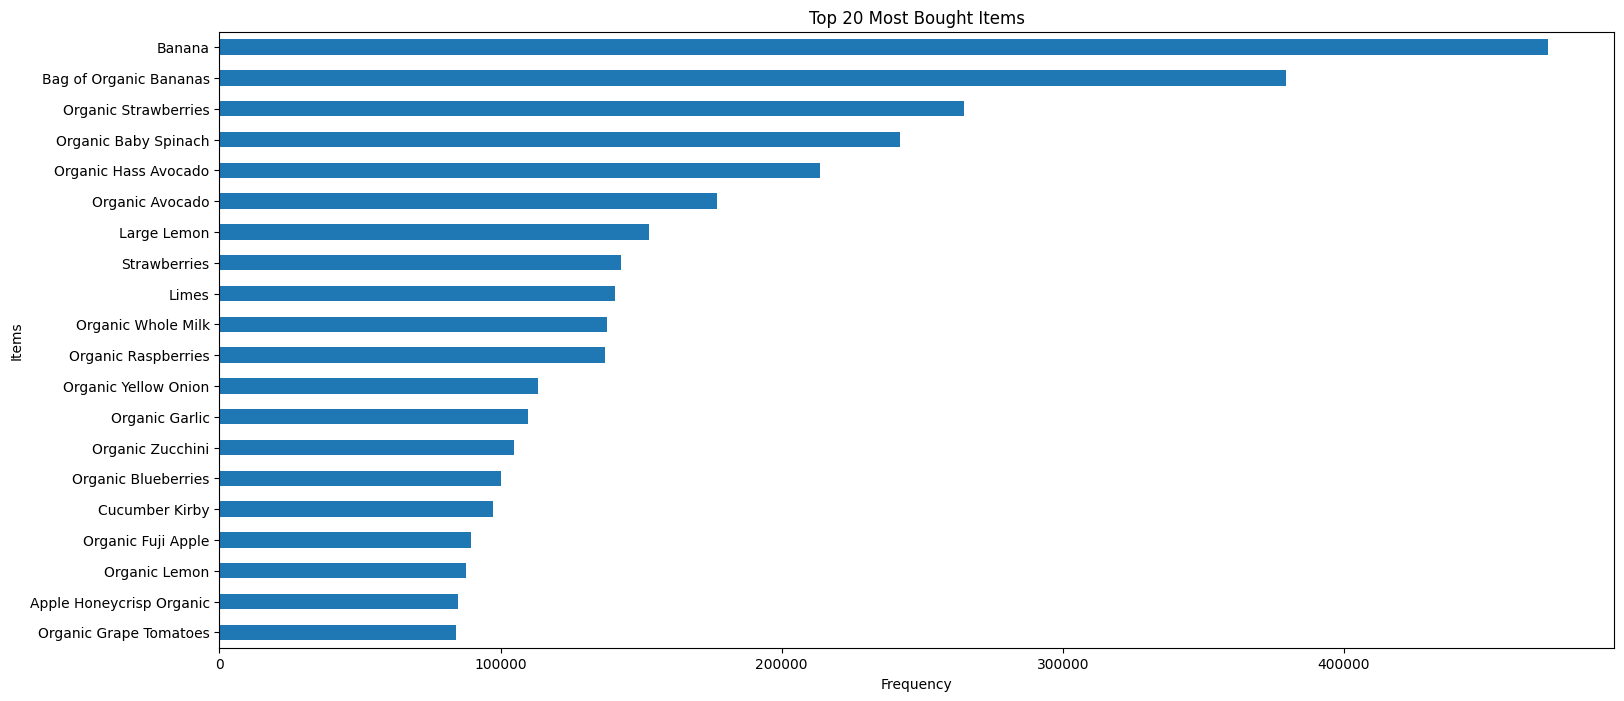

In [14]:
# Set the size of the plot
plt.figure(figsize=(18,8))

# Identify the top 20 most frequently purchased items
top_20 = filtered_data['product_name'].value_counts().head(20).sort_values(ascending=True)

# Plot a horizontal bar chart of the top 20 most frequently purchased items
top_20.plot(kind='barh')

# Set the title of the bar chart
plt.title('Top 20 Most Bought Items')

# Label the x-axis as 'Frequency'
plt.xlabel('Frequency')

# Label the y-axis as 'Items'
plt.ylabel('Items')

# Display the plot
plt.show()

`Banana` was the most bought product with more than 470,000 purchases, followed by `Bag of Organic Bananas` and `Organic Strawberries` with 370,000 and 260,000 purchases respectively.



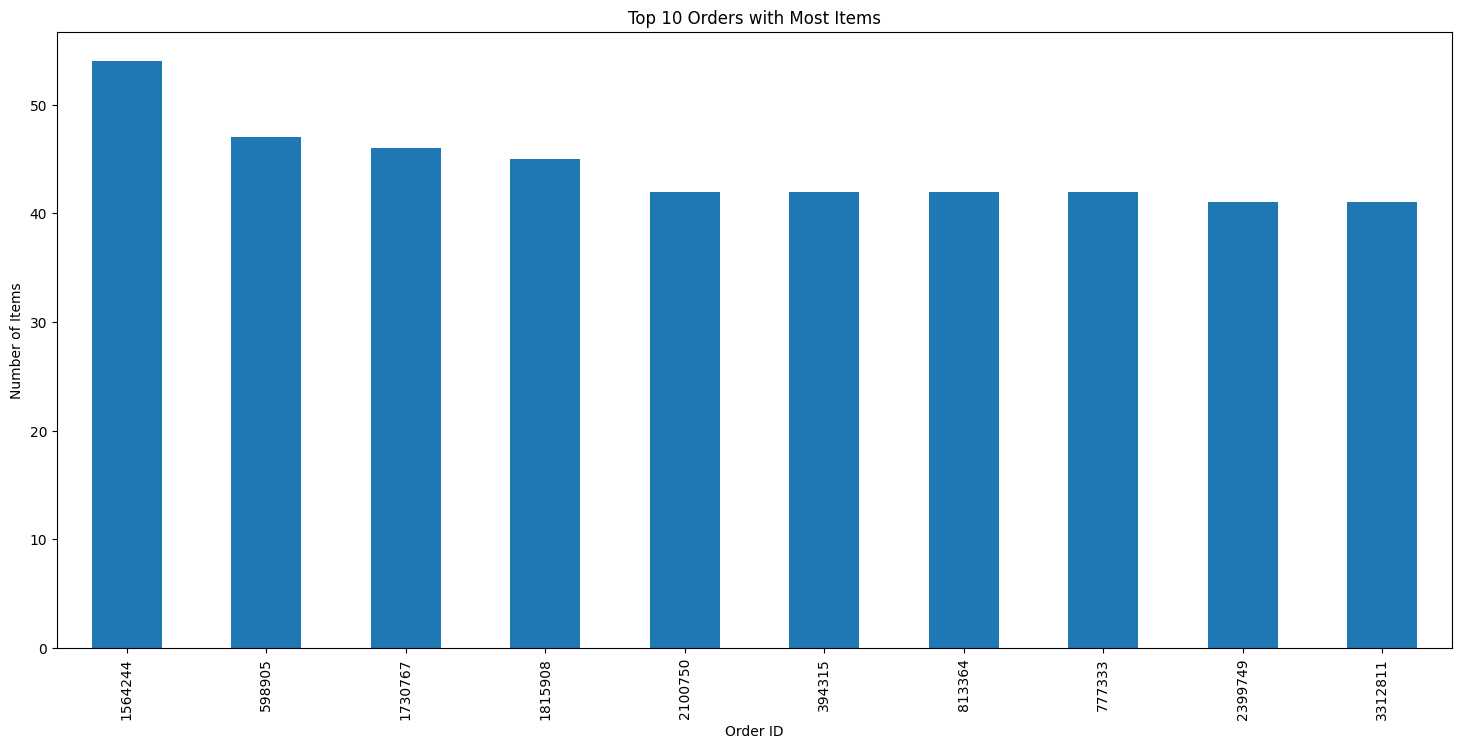

In [15]:
# Set the size of the plot
plt.figure(figsize=(18,8))

# Identify the top 10 orders with the most items
top_10_orders = filtered_data.order_id.value_counts().head(10)

# Plot a bar chart of the top 10 orders with the most items
top_10_orders.plot(kind='bar')

# Set the title of the bar chart
plt.title('Top 10 Orders with Most Items')

# Label the x-axis as 'Order ID'
plt.xlabel('Order ID')

# Label the y-axis as 'Number of Items'
plt.ylabel('Number of Items')

# Display the plot
plt.show()

Order number 1564244 holds the record as the largest order, containing a total of 54 items.

In [16]:
# Print the average number of items bought per order
print("The average number of items bought per order is:", round(filtered_data.order_id.value_counts().mean(), 1))

The average number of items bought per order is: 4.8


In [17]:
# Generate descriptive statistics
filtered_data.describe()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id
count,13395934.00,13395934.00,13395934.00,13395934.00,13395934.00,13395934.00
mean,1710921.37,26766.62,7.80,0.68,69.38,7.87
std,987195.79,13690.25,6.64,0.47,37.84,5.70
min,2.00,45.00,1.00,0.00,3.00,1.00
25%,856207.00,16797.00,3.00,0.00,24.00,4.00
50%,1711435.00,26209.00,6.00,1.00,83.00,4.00
75%,2565216.00,39275.00,11.00,1.00,96.00,15.00
max,3421083.00,49683.00,140.00,1.00,131.00,20.00


In [18]:
# Display data types of each column, and memory usage
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13395934 entries, 0 to 24689958
Data columns (total 7 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   order_id           int64 
 1   product_id         int64 
 2   add_to_cart_order  int64 
 3   reordered          int64 
 4   product_name       object
 5   aisle_id           int64 
 6   department_id      int64 
dtypes: int64(6), object(1)
memory usage: 817.6+ MB


*Changing the data types of each column will help us save some memory. It is mostly useful when creating the basket DataFrame, as it enables us to work with more data.*

In [19]:
# Change the data types of several columns to save memory
filtered_data['order_id'] = filtered_data['order_id'].astype('int32')
filtered_data['product_id'] = filtered_data['product_id'].astype('uint16')
filtered_data['reordered'] = filtered_data['reordered'].astype('int8')

# Drop several columns that are not necessary for the analysis
filtered_data.drop(['department_id', 'aisle_id', 'add_to_cart_order'], axis=1, inplace=True)

# Display the new data types, and memory usage of the DataFrame after preprocessing
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13395934 entries, 0 to 24689958
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   order_id      int32 
 1   product_id    uint16
 2   reordered     int8  
 3   product_name  object
dtypes: int32(1), int8(1), object(1), uint16(1)
memory usage: 293.8+ MB


In [20]:
# Create a product basket DataFrame, with each row as an order and columns as products
basket = (filtered_data.groupby(['order_id', 'product_name'])['reordered'].count()
          .unstack().reset_index().fillna(0).set_index('order_id'))

# Display the first few rows of the basket DataFrame
basket.head()

product_name,0% Greek Strained Yogurt,1% Lowfat Milk,100 Calorie Per Bag Popcorn,100% Raw Coconut Water,100% Recycled Paper Towels,100% Whole Wheat Bread,2% Reduced Fat DHA Omega-3 Reduced Fat Milk,2% Reduced Fat Milk,2% Reduced Fat Organic Milk,85% Lean Ground Beef,...,White Onion,Whole Almonds,Whole Milk,Whole Milk Plain Yogurt,XL Emerald White Seedless Grapes,Yellow Bell Pepper,Yellow Onions,YoKids Blueberry & Strawberry/Vanilla Yogurt,"YoKids Squeezers Organic Low-Fat Yogurt, Strawberry","Yogurt, Strained Low-Fat, Coconut"
order_id,,,,,,,,,,,,,,,,,,,,,
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [21]:
# Checking the memory usage of the `basket` DataFrame
basket.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2783957 entries, 2 to 3421083
Columns: 450 entries, 0% Greek Strained Yogurt to Yogurt, Strained Low-Fat, Coconut
dtypes: float64(450)
memory usage: 9.3 GB


In [22]:
# Change the data types of the basket dataframe to save memory
basket = basket.astype('uint8')

# Checking the new memory usage of the `basket` DataFrame
basket.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2783957 entries, 2 to 3421083
Columns: 450 entries, 0% Greek Strained Yogurt to Yogurt, Strained Low-Fat, Coconut
dtypes: uint8(450)
memory usage: 1.2 GB


*Switching to more memory-efficient datatypes enables us to work more effectively with larger datasets. As evidenced by our reduction in memory usage from 9.3 GB down to 1.2 GB, we achieved over seven times improvement in memory efficiency.*

In [23]:
# Apply encoding to the basket DataFrame, ensuring all values exceeding 1 are clipped to 1.
# This prepares the data for association rule mining, where we're only interested in whether
# a product is included in an order (1), not its quantity.
basket_encoded = basket.clip(0, 1)

# Display the first few rows of the `basket_encoded` DataFrame
basket_encoded.head()

product_name,0% Greek Strained Yogurt,1% Lowfat Milk,100 Calorie Per Bag Popcorn,100% Raw Coconut Water,100% Recycled Paper Towels,100% Whole Wheat Bread,2% Reduced Fat DHA Omega-3 Reduced Fat Milk,2% Reduced Fat Milk,2% Reduced Fat Organic Milk,85% Lean Ground Beef,...,White Onion,Whole Almonds,Whole Milk,Whole Milk Plain Yogurt,XL Emerald White Seedless Grapes,Yellow Bell Pepper,Yellow Onions,YoKids Blueberry & Strawberry/Vanilla Yogurt,"YoKids Squeezers Organic Low-Fat Yogurt, Strawberry","Yogurt, Strained Low-Fat, Coconut"
order_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Print the dimensions of 'basket_encoded'
print(f"The number of rows and columns in the 'basket_encoded' DataFrame: {basket_encoded.shape}")

The number of rows and columns in the 'basket_encoded' DataFrame: (2783957, 450)


## Apriori Algorithm

*In this segment, we'll employ the apriori algorithm to identify the items that are purchased most frequently in our dataset. We'll set our minimum support threshold at 1%, implying that only items appearing in at least 1% of the transactions will be considered.*

In [25]:
# Use the apriori algorithm to find frequent itemsets in the encoded basket
frequent_itemsets = apriori(basket_encoded, min_support=0.01, use_colnames=True, low_memory=True).sort_values("support", ascending=False)

# Display the top 10 frequent itemsets
frequent_itemsets.head(10)

,support,itemsets
7,0.17,(Banana)
6,0.14,(Bag of Organic Bananas)
88,0.10,(Organic Strawberries)
44,0.09,(Organic Baby Spinach)
66,0.08,(Organic Hass Avocado)
40,0.06,(Organic Avocado)
34,0.05,(Large Lemon)
114,0.05,(Strawberries)
36,0.05,(Limes)
91,0.05,(Organic Whole Milk)


*The output shows that the Banana is the item bought most often, with a support value of 0.17. This signifies that this particular item features in 17% of all transactions. This further substantiates the observations we made earlier.*

## Association Rules

*The concluding stage of our analysis involves producing rules along with their associated support, confidence, and lift metrics. This process allows us to glean valuable insights regarding which items are often bought in conjunction.*

In [26]:
# Generate association rules from the frequent itemsets using the 'lift' metric. Set a minimum lift threshold of 1
assoc_rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1).sort_values("lift", ascending=False).reset_index(drop=True)

# Display the generated association rules
assoc_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Raspberries),(Organic Strawberries),0.05,0.10,0.01,0.25,2.60,0.01,1.20,0.65
1,(Organic Strawberries),(Organic Raspberries),0.10,0.05,0.01,0.13,2.60,0.01,1.09,0.68
2,(Banana),(Organic Fuji Apple),0.17,0.03,0.01,0.07,2.23,0.01,1.04,0.66
3,(Organic Fuji Apple),(Banana),0.03,0.17,0.01,0.38,2.23,0.01,1.34,0.57
4,(Organic Raspberries),(Bag of Organic Bananas),0.05,0.14,0.01,0.30,2.17,0.01,1.23,0.57
5,(Bag of Organic Bananas),(Organic Raspberries),0.14,0.05,0.01,0.11,2.17,0.01,1.06,0.62
6,(Bag of Organic Bananas),(Organic Hass Avocado),0.14,0.08,0.02,0.16,2.14,0.01,1.10,0.62
7,(Organic Hass Avocado),(Bag of Organic Bananas),0.08,0.14,0.02,0.29,2.14,0.01,1.22,0.58
8,(Banana),(Honeycrisp Apple),0.17,0.03,0.01,0.06,2.10,0.01,1.03,0.63
9,(Honeycrisp Apple),(Banana),0.03,0.17,0.01,0.36,2.10,0.01,1.29,0.54


Based on the results from implementing association rules, we can see that 'Organic Raspberries' and 'Organic Strawberries' have the highest lift value, and therefore the highest association of any two products. With a combined support of 0.01, it means both items were purchased together in 1% of all transactions. As far as what marketing strategy to implement with this insight, that will depend on a variety of factors and is a perfect example of how domain knowledge in retail will come in handy. Given that this is an online store, it’s a no-brainer to display each consequent product as a recommendation on the antecedent product page, thereby using the popularity of one product to drive the sales of the other. Another way to attract more sales is to bundle the associated products and implement a bundle pricing technique or a sales promotion around both items.

## Conclusion

This notebook demonstrated the implementation of market basket analysis on Instscart data using the apriori algorithm and association rules. The process provided actionable insights by uncovering relationships between products that are frequently purchased together. A key benefit of this technique is its interpretability and ease of implementation, making the results readily usable for data-driven marketing decisions. Beyond retail, market basket analysis has diverse applications including predictive maintenance in manufacturing, drug discovery in pharmaceuticals, and fraud detection in finance. Overall, this method enables discoveries of underlying patterns in transaction data across industries to derive strategic business value.

### Limitations and Solutions

The Apriori algorithm, while powerful, has limitations such as computational inefficiency with large datasets. In this notebook, we have used only 41% of the available data due to these constraints. However, solutions exist to overcome these limitations. By leveraging distributed computing frameworks like Apache Spark, we can efficiently process larger datasets, greatly enhancing scalability and processing speed. This enables us to utilize the full dataset for more robust and comprehensive analysis.